# Modelo

### Librerías y carga del dataset

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import os

# Directorio que contiene los archivos pkl
directorio = '../data/'  # Actualiza con la ruta correcta

# Lista para almacenar los DataFrames de los archivos pkl
dataframes = []

# Recorre los archivos en el directorio
for archivo in os.listdir(directorio):
    if archivo.endswith('.pkl'):
        ruta_archivo = os.path.join(directorio, archivo)
        with open(ruta_archivo, 'rb') as f:
            data = pickle.load(f)
        dataframes.append(data)

# Combina los DataFrames en uno solo
data = pd.concat(dataframes, ignore_index=True)

### Datos sin procesar

In [2]:
print(data.head())
print("filas-data-sucia: ", len(data))

   TRANSACTION_ID TIEMPO_DESDE_ULTIMA_TX_S DIA_TX CLIENTE_ID TERMINAL_ID  \
0          407068                  6134602     71       8174          16   
1          407069                  6134814     71       7162         130   
2          407070                  6135010     71       6635         312   
3          407071                  6135020     71       2010         172   
4          407072                  6135040     71        418         330   

    MONTO_TX         TX_DATETIME    year  month  day  hour  minute  \
0   76381.42 2023-04-06 00:03:22  2023.0    4.0  6.0   0.0     3.0   
1  119366.58 2023-04-06 00:06:54  2023.0    4.0  6.0   0.0     6.0   
2   26636.46 2023-04-06 00:10:10  2023.0    4.0  6.0   0.0    10.0   
3   83394.98 2023-04-06 00:10:20  2023.0    4.0  6.0   0.0    10.0   
4  123831.11 2023-04-06 00:10:40  2023.0    4.0  6.0   0.0    10.0   

   x_pos_terminal  y_pos_terminal  TX_FRAUD  TX_FRAUD_SCENARIO  
0       47.894477       26.658264         0              

### Datos filtrados

In [3]:
data = data.drop('TRANSACTION_ID', axis=1)
data = data.drop('CLIENTE_ID', axis=1)
data = data[data['TX_FRAUD'] == 1]
data = data.sort_values(by=['TX_DATETIME'])
print(data.head())
print("total-filas: ",len(data) )

      TIEMPO_DESDE_ULTIMA_TX_S DIA_TX TERMINAL_ID   MONTO_TX  \
28733                     1524      0         466  139447.11   
28738                     1805      0         406   92739.05   
28740                     1911      0         363  115776.96   
28753                     2544      0         483  139610.64   
28754                     2552      0         115  132291.02   

              TX_DATETIME    year  month   day  hour  minute  x_pos_terminal  \
28733 2023-01-25 00:25:24  2023.0    1.0  25.0   0.0    25.0        1.287674   
28738 2023-01-25 00:30:05  2023.0    1.0  25.0   0.0    30.0       46.924095   
28740 2023-01-25 00:31:51  2023.0    1.0  25.0   0.0    31.0       42.144992   
28753 2023-01-25 00:42:24  2023.0    1.0  25.0   0.0    42.0       23.700314   
28754 2023-01-25 00:42:32  2023.0    1.0  25.0   0.0    42.0       22.994013   

       y_pos_terminal  TX_FRAUD  TX_FRAUD_SCENARIO  
28733       14.557697         1                  1  
28738       17.151405       

### Random Forest

Mean Squared Error (MSE): 0.9386665655270002
Mean Absolute Error (MAE): 0.7355921569067818
R-squared: 0.8783442646899142


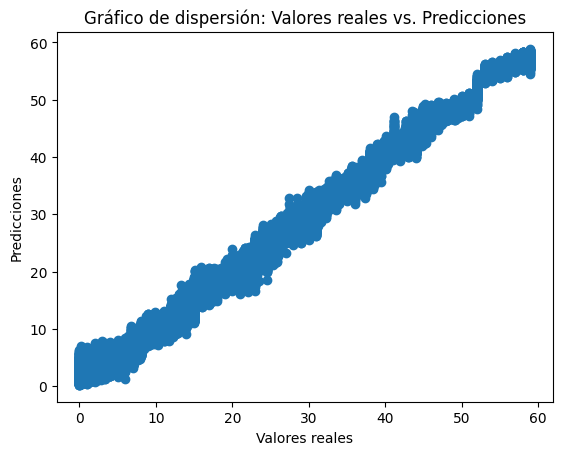

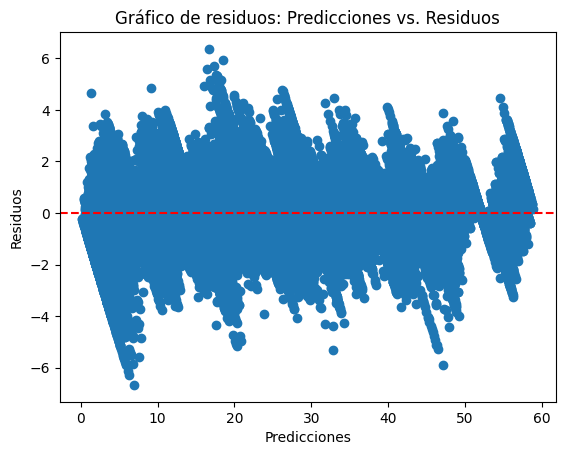

In [4]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
# Variables de entrada
X = data[['x_pos_terminal', 'y_pos_terminal','month', 'day', 'hour', 'minute']]
# Variables objetivo
y = data[['x_pos_terminal', 'y_pos_terminal','month','day', 'hour', 'minute']]

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(oob_score=True)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)

plt.scatter(y_test, y_pred)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Gráfico de dispersión: Valores reales vs. Predicciones')
plt.show()

# Calcular los residuos
residuals = y_test - y_pred

# Gráfico de residuos
plt.scatter(y_pred, residuals)
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos: Predicciones vs. Residuos')
plt.axhline(y=0, color='r', linestyle='--')  # Línea de referencia en 0
plt.show()

### Curvas de aprendizaje

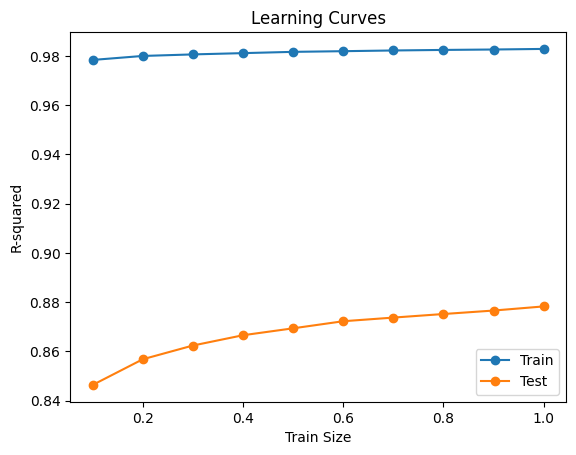

In [5]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_scores = []
test_scores = []

for train_size in train_sizes:
    # Tamaño del conjunto de entrenamiento actual
    current_train_size = int(train_size * len(X_train))
    
    # Subconjunto de entrenamiento actual
    X_train_subset = X_train[:current_train_size]
    y_train_subset = y_train[:current_train_size]
    
    # Entrenar el modelo
    model = RandomForestRegressor(oob_score=True)
    model.fit(X_train_subset, y_train_subset)
    
    # Predecir en el conjunto de entrenamiento y prueba
    y_train_pred = model.predict(X_train_subset)
    y_test_pred = model.predict(X_test)
    
    # Calcular el rendimiento (por ejemplo, R-squared)
    train_score = r2_score(y_train_subset, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    
    # Agregar a las listas de puntajes
    train_scores.append(train_score)
    test_scores.append(test_score)

# Graficar las curvas de aprendizaje
plt.plot(train_sizes, train_scores, 'o-', label='Train')
plt.plot(train_sizes, test_scores, 'o-', label='Test')
plt.xlabel('Train Size')
plt.ylabel('R-squared')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [6]:
y_pred_rounded = y_pred.copy()  # Copia los valores predichos

# Redondea los valores a enteros en las últimas 4 columnas
y_pred_rounded[:, -4:] = y_pred_rounded[:, -4:].round().astype(int)

print(y_pred_rounded)
rounded_df = pd.DataFrame(y_pred_rounded, columns=y_test.columns)
rounded_df.to_csv('../output/predicciones.csv', index=False)

[[16.44327411  8.42108786  2.         28.          4.         10.        ]
 [41.09622568  9.86346798  3.          3.         10.         42.        ]
 [32.73579817 22.24266236  3.         13.          3.         39.        ]
 ...
 [11.00447146 23.7910903   3.         21.          5.         49.        ]
 [ 7.18043065 12.50231691  3.         12.         15.         10.        ]
 [ 1.68655053 25.5047532   3.         11.         20.         20.        ]]


### Validación

In [7]:
validacion_directorio = '../validation/'

dataframe_validation = []

for archivo in os.listdir(validacion_directorio):
    if archivo.endswith('.pkl'):
        ruta_archivo = os.path.join(validacion_directorio, archivo)
        with open(ruta_archivo, 'rb') as f:
            data_val = pickle.load(f)
        dataframe_validation.append(data_val)

# Combina los DataFrames en uno solo
data_val = pd.concat(dataframe_validation, ignore_index=True)

In [8]:
data_val = data_val.drop('TRANSACTION_ID', axis=1)
data_val = data_val.drop('CLIENTE_ID', axis=1)
data_val = data_val[data_val['TX_FRAUD'] == 1]
data_val = data_val.sort_values(by=['TX_DATETIME'])
print(data_val.head())
print("total-filas: ",len(data_val) )

      TIEMPO_DESDE_ULTIMA_TX_S DIA_TX TERMINAL_ID   MONTO_TX  \
50871                     1524      0         466  139447.11   
50873                     1805      0         406   92739.05   
50874                     1911      0         363  115776.96   
50877                     3108      0          99  124855.45   
50878                     3445      0          65   82575.39   

              TX_DATETIME    year  month   day  hour  minute  x_pos_terminal  \
50871 2023-02-25 00:25:24  2023.0    2.0  25.0   0.0    25.0        1.287674   
50873 2023-02-25 00:30:05  2023.0    2.0  25.0   0.0    30.0       46.924095   
50874 2023-02-25 00:31:51  2023.0    2.0  25.0   0.0    31.0       42.144992   
50877 2023-02-25 00:51:48  2023.0    2.0  25.0   0.0    51.0       30.838918   
50878 2023-02-25 00:57:25  2023.0    2.0  25.0   0.0    57.0       29.287964   

       y_pos_terminal  TX_FRAUD  TX_FRAUD_SCENARIO  
50871       14.557697         1                  1  
50873       17.151405       

In [9]:
X_val = data_val[['x_pos_terminal', 'y_pos_terminal','month', 'day', 'hour', 'minute']]
# Variables objetivo
y_val = data_val[['x_pos_terminal', 'y_pos_terminal','month','day', 'hour', 'minute']]

# Realizar predicciones en el conjunto de prueba
y_pred_val = model.predict(X_val)

y_pred_val_original = y_pred_val.copy()  # Copia los valores predichos

y_pred_rounded_val = y_pred_val.copy()  # Copia los valores predichos

# Redondea los valores a enteros en las últimas 4 columnas
y_pred_rounded_val[:, -4:] = y_pred_rounded_val[:, -4:].round().astype(int)

print(y_pred_rounded_val)
rounded_df_val = pd.DataFrame(y_pred_rounded_val, columns=y_val.columns)
rounded_df_val.to_csv('../output/predicciones_val.csv', index=False)

# Calcular las métricas
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Imprimir las métricas
print("VAL - Mean Squared Error (MSE):", mse_val)
print("VAL - Mean Absolute Error (MAE):", mae_val)
print("VAL - R-squared:", r2_val)


[[ 3.72119779 12.54354438  2.         26.          5.         25.        ]
 [46.79284134 17.22993493  1.         25.          2.         31.        ]
 [41.87329375  2.46429989  1.         26.          1.         32.        ]
 ...
 [46.15467013 10.97187408  3.         14.         22.         43.        ]
 [16.24147573 27.84948098  3.         14.         20.         48.        ]
 [36.00945537  6.26166376  3.         14.         22.         56.        ]]
VAL - Mean Squared Error (MSE): 0.6482624198625443
VAL - Mean Absolute Error (MAE): 0.5918764671524606
VAL - R-squared: 0.7820748676626841


In [10]:
print(y_pred_val_original)

[[ 3.72119779 12.54354438  1.86       25.8         4.86       25.23      ]
 [46.79284134 17.22993493  1.46       25.03        1.77       30.63      ]
 [41.87329375  2.46429989  1.46       25.9         1.24       32.48      ]
 ...
 [46.15467013 10.97187408  3.41       13.86       21.84       42.7       ]
 [16.24147573 27.84948098  2.99       14.4        20.49       48.01      ]
 [36.00945537  6.26166376  3.28       14.16       21.67       55.67      ]]
